In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import cv2
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical

2025-05-08 02:39:53.842777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746671994.048810      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746671994.108677      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
tf.__version__,cv2.__version__

('2.18.0', '4.11.0')

In [3]:
!python --version

Python 3.11.11


In [4]:
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 📊 Data Description
The dataset used for this project is a histopathological image dataset of lung and colon cancer, structured into five (5) clearly labeled classes based on tissue type and diagnosis. It includes high-resolution microscopic images of stained tissue sections.

# 📁 Classes in the Dataset
The dataset is divided into the following five classes, each representing a distinct tissue type:

1.colon_aca – Colon adenocarcinoma (malignant tumor in the colon lining).

2.colon_bnt – Benign colon tissue (non-cancerous).

3.lung_aca – Lung adenocarcinoma (a type of non-small cell lung cancer).

4.lung_bnt – Benign lung tissue (non-cancerous lung cells).

5.lung_scc – Lung squamous cell carcinoma (cancer arising from squamous cells in the lungs).

## Data Visualization 
show samples from data

/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/colon_bnt
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/colon_aca
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_aca
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_bnt
/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer/lung_scc


  0%|          | 0/16 [00:00<?, ?it/s]

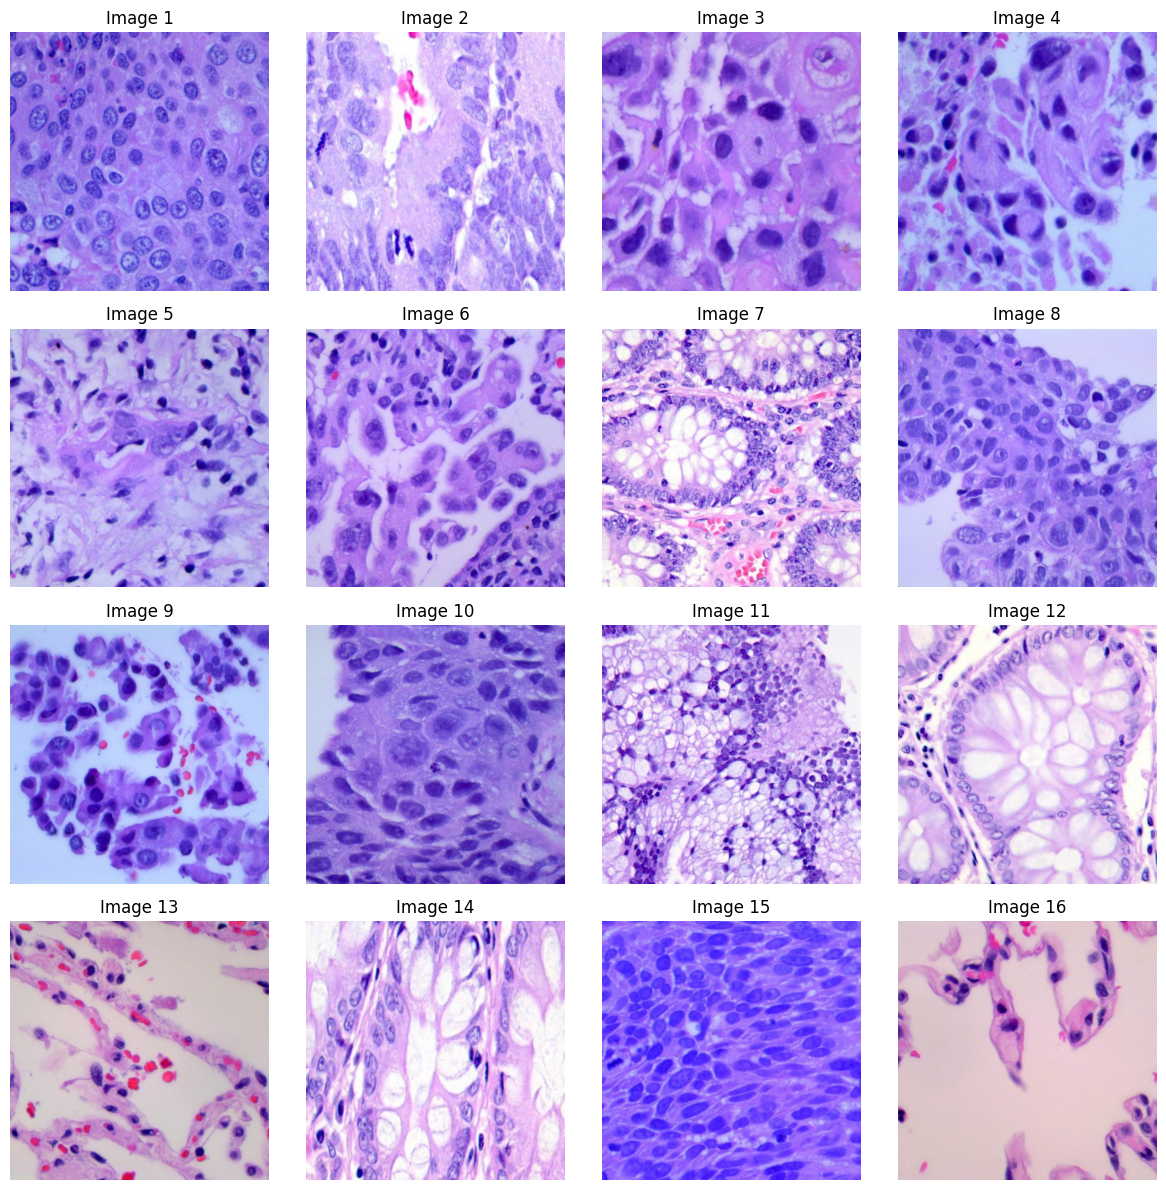

In [5]:
main_folder = r'/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer'

# Get all image paths
images = []
for folder in os.listdir(main_folder):
    path = os.path.join(main_folder,folder)
    print(path)
    for img in os.listdir(path):
        if img.endswith(('.jpg', '.png', '.webp')):
            images.append(os.path.join(path, img)) 

# Pick 16 random images
random_images = random.sample(images, 16)

# Plot them
plt.figure(figsize=(12, 12))
for i, img_path in enumerate(tqdm(random_images)):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.title(f'Image {i+1}')
    
plt.tight_layout()
plt.show()

## Data splitting

In [6]:
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Main folder containing the images
main_folder = '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Lung and Colon Cancer'

# Collect image paths and their corresponding labels
filepaths = []
labels = []

for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)
    if os.path.isdir(folder_path):
        for img in os.listdir(folder_path):
            if img.endswith(('.jpg', '.png', '.jpeg', '.webp')):
                filepaths.append(os.path.join(folder_path, img))
                labels.append(folder)

# X = image file paths, y = class labels
X = pd.Series(filepaths, name="filepath")
y = pd.Series(labels, name="label")

# Split into Train / Temp (30% temp for validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Split Temp into Validation / Test (each 15% of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Combine into DataFrames for further use
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))


Train size: 17500
Validation size: 3750
Test size: 3750


# CNN Model
*Components:*

* Convolutional layers (Conv2D) for feature extraction
* MaxPooling layers for spatial reduction
* Dropout layers to prevent overfitting
* Flatten and Dense layers for classification


In [7]:
IMG_SIZE = 224
batch_size = 32

In [8]:
def cnn_preprocess(x):
    return x/255.0

# CNN Data Generators

In [9]:
# ImageDataGenerator
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

# Using flow_from_dataframe instead of flow_from_directory
cnn_train_generator = cnn_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 17500 validated image filenames belonging to 5 classes.


In [10]:
cnn_train_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [11]:
# ImageDataGenerator for val data
cnn_val_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)

cnn_val_generator = cnn_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 3750 validated image filenames belonging to 5 classes.


In [12]:
cnn_val_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

# Build CNN Model

In [13]:
with tf.device('/GPU:0'):
    cnn_model = keras.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_val_generator.class_indices), activation='softmax', dtype='float32')
])


I0000 00:00:1746672044.942661      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,201,029 (42.73 MB)

 Trainable params: 11,201,029 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

# compiling

In [16]:
cnn_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [17]:
with tf.device('/GPU:0'):
    cnn_history = cnn_model.fit(
        cnn_train_generator,
        epochs = 12,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/12


I0000 00:00:1746672052.942710      65 service.cc:148] XLA service 0x2a4f8340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746672052.943611      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746672053.368586      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/547 ━━━━━━━━━━━━━━━━━━━━ 1:36:53 11s/step - accuracy: 0.2812 - loss: 1.6151 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1746672057.966811      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.6458 - loss: 0.7878 - precision: 0.7041 - recall: 0.5631
Epoch 1: val_loss improved from inf to 0.47785, saving model to CNN_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 170s 292ms/step - accuracy: 0.6461 - loss: 0.7869 - precision: 0.7043 - recall: 0.5637 - val_accuracy: 0.8163 - val_loss: 0.4778 - val_precision: 0.8281 - val_recall: 0.8093
Epoch 2/12
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8478 - loss: 0.3602 - precision: 0.8528 - recall: 0.8424
Epoch 2: val_loss improved from 0.47785 to 0.26883, saving model to CNN_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 64s 116ms/step - accuracy: 0.8479 - loss: 0.3601 - precision: 0.8529 - recall: 0.8425 - val_accuracy: 0.8888 - val_loss: 0.2688 - val_precision: 0.8900 - val_recall: 0.8867
Epoch 3/12
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9194 - loss: 0.2093 - precision: 0.9209 - recall: 0.9174
Epoch 3: val_loss did not improve from 0.26883
547/547 ━━━━

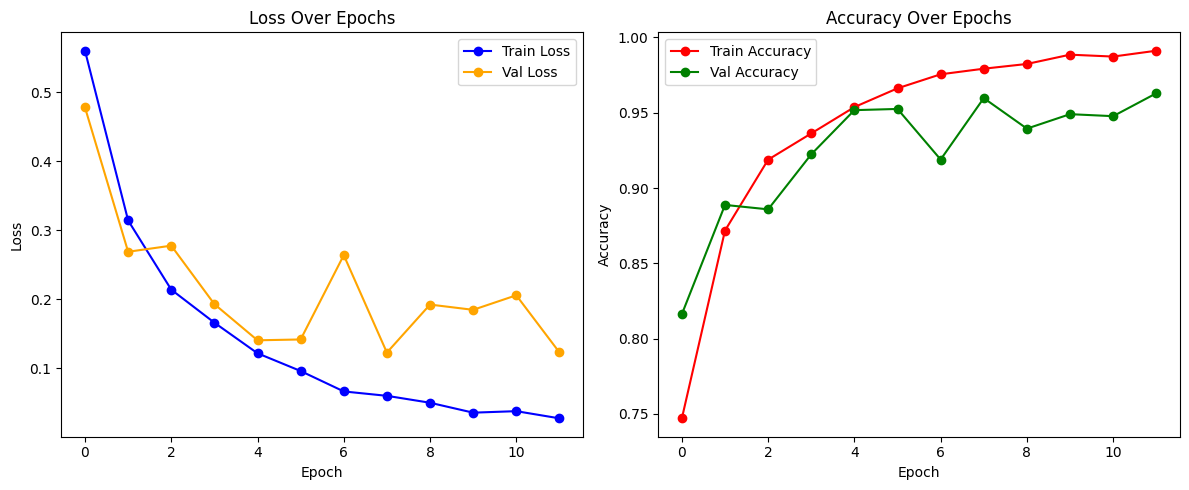

In [18]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# VGG16 Data Generators

In [19]:
IMG_SIZE = 224
batch_size = 32

In [20]:
def preprocess_vgg16(x):
    return tf.keras.applications.vgg16.preprocess_input(x)

# VGG16 Data Generators

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup DataGenerator for training
VGG16_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)

# Prepare the data generator from DataFrame (train_df)
VGG16_train_generator = VGG16_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',      # Column for file paths
    y_col='label',         # Column for labels
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 17500 validated image filenames belonging to 5 classes.


In [22]:
VGG16_train_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [23]:
VGG16_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_vgg16)

VGG16_val_generator = VGG16_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 3750 validated image filenames belonging to 5 classes.


In [24]:
VGG16_val_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

# VGG16 Modeling

In [25]:
trained_VGG16_layers = VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
for layer in trained_VGG16_layers.layers:
    layer.trainable = False


In [27]:
with tf.device('/GPU:0'):
    VGG16_model = keras.models.Sequential([
    trained_VGG16_layers,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(VGG16_val_generator.class_indices), activation='softmax')
]) 


In [28]:
VGG16_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=3,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='VGG16_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

# Compiling

In [30]:
VGG16_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [31]:
with tf.device('/GPU:0'):
    VGG16_history = VGG16_model.fit(
        VGG16_train_generator,
        epochs = 12,
        validation_data = VGG16_val_generator,
        callbacks = callbacks
        )


Epoch 1/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8912 - loss: 4.0590 - precision: 0.8912 - recall: 0.8912
Epoch 1: val_loss improved from inf to 0.60505, saving model to VGG16_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 95s 154ms/step - accuracy: 0.8913 - loss: 4.0542 - precision: 0.8913 - recall: 0.8913 - val_accuracy: 0.9531 - val_loss: 0.6050 - val_precision: 0.9531 - val_recall: 0.9531
Epoch 2/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9841 - loss: 0.1156 - precision: 0.9841 - recall: 0.9841
Epoch 2: val_loss improved from 0.60505 to 0.30773, saving model to VGG16_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 74s 133ms/step - accuracy: 0.9841 - loss: 0.1156 - precision: 0.9841 - recall: 0.9841 - val_accuracy: 0.9715 - val_loss: 0.3077 - val_precision: 0.9715 - val_recall: 0.9715
Epoch 3/12
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9912 - loss: 0.0536 - precision: 0.9912 - recall: 0.9912
Epoch 3: val_loss improved from 0.30773 to 

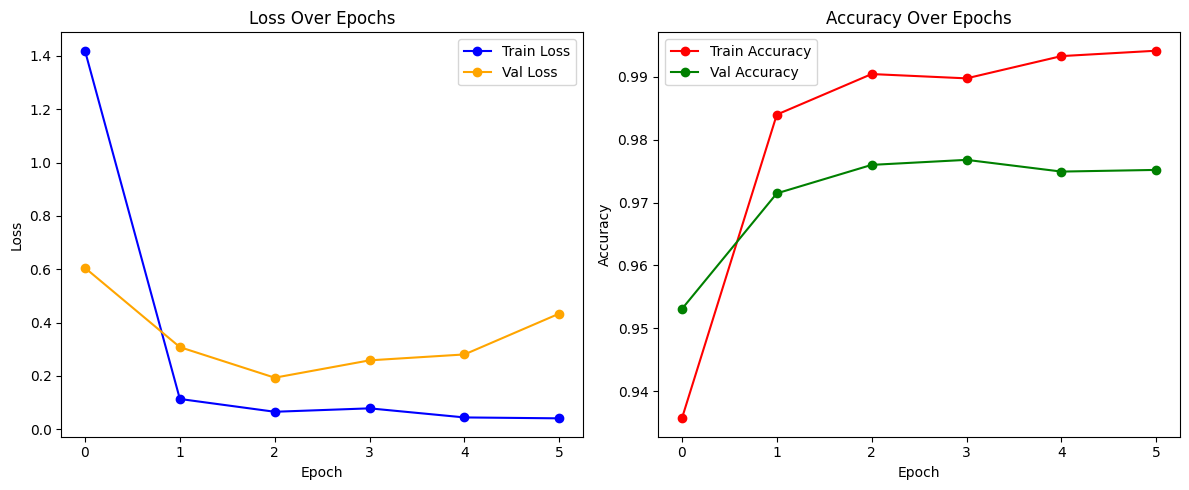

In [32]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(VGG16_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(VGG16_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(VGG16_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(VGG16_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# ResNet50V2 Model

In [33]:
IMG_SIZE = 224
batch_size = 32

# ResNet50V2 Generator

In [34]:
ResNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet50v2)

# Data generator for training
ResNet_train_generator = ResNet_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',       # Image paths
    y_col='label',          # Labels
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 17500 validated image filenames belonging to 5 classes.


In [35]:
ResNet_train_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [36]:
ResNet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_resnet50v2)

# Data generator for validation
ResNet_val_generator = ResNet_val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 3750 validated image filenames belonging to 5 classes.


In [37]:
ResNet_val_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [38]:
trained_ResNet_layers = ResNet50V2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [39]:
for layer in trained_ResNet_layers.layers:
    layer.trainable = False

# Modelling

In [40]:
with tf.device('/GPU:0'):
    ResNet_model = keras.models.Sequential([
    trained_ResNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(ResNet_val_generator.class_indices), activation='softmax')
]) 

In [41]:
ResNet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,090,629 (91.90 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [42]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=3,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='ResNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

# compiling

In [43]:
ResNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [44]:
with tf.device('/GPU:0'):
    ResNet_history = ResNet_model.fit(
        ResNet_train_generator,
        epochs = 12,
        validation_data = ResNet_val_generator,
        callbacks = callbacks
        )

Epoch 1/12
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9192 - loss: 0.2155 - precision: 0.9332 - recall: 0.9083
Epoch 1: val_loss improved from inf to 0.06573, saving model to ResNet_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.9193 - loss: 0.2152 - precision: 0.9332 - recall: 0.9085 - val_accuracy: 0.9779 - val_loss: 0.0657 - val_precision: 0.9781 - val_recall: 0.9776
Epoch 2/12
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9789 - loss: 0.0495 - precision: 0.9789 - recall: 0.9787
Epoch 2: val_loss improved from 0.06573 to 0.05279, saving model to ResNet_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 68s 124ms/step - accuracy: 0.9789 - loss: 0.0495 - precision: 0.9789 - recall: 0.9787 - val_accuracy: 0.9805 - val_loss: 0.0528 - val_precision: 0.9805 - val_recall: 0.9805
Epoch 3/12
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9882 - loss: 0.0303 - precision: 0.9882 - recall: 0.9881
Epoch 3: val_loss improved from 0.05279 t

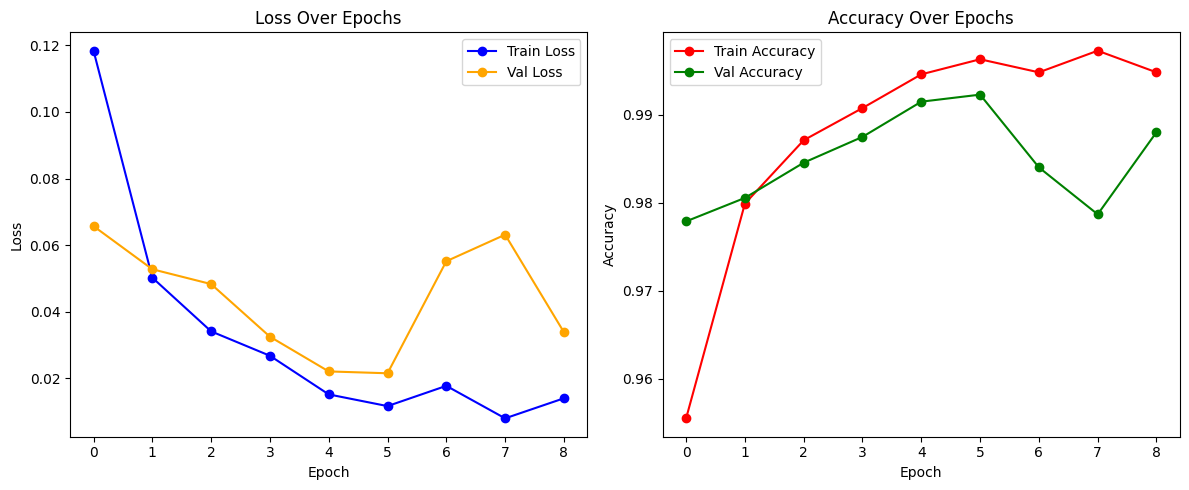

In [45]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(ResNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(ResNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(ResNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(ResNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# MobileNetV2 Model

In [46]:
IMG_SIZE = 224
batch_size = 32

# MobileNet Generator

In [47]:
MobileNet_train_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenetv2)

MobileNet_train_generator = MobileNet_train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

Found 17500 validated image filenames belonging to 5 classes.


In [48]:
MobileNet_train_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [49]:
# Validation Data Generator
MobileNet_val_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenetv2)

# Create the validation data generator
MobileNet_val_generator = MobileNet_val_datagen.flow_from_dataframe(
    dataframe=val_df,            # The DataFrame containing validation data
    x_col='filepath',            # The column with file paths to images
    y_col='label',               # The column with the corresponding labels
    target_size=(IMG_SIZE, IMG_SIZE),  # Resize images to the required input size for MobileNetV2
    batch_size=batch_size,       # Number of samples per batch
    class_mode='categorical',    # Since it's multi-class classification, use categorical
    shuffle=False,               # Don't shuffle the validation data (important for evaluation)
    seed=42                      # Set the seed for reproducibility
)

Found 3750 validated image filenames belonging to 5 classes.


In [50]:
MobileNet_val_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

# MobileNetV2 Modeling

In [51]:
trained_MobileNet_layers = MobileNetV2(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [52]:
for layer in trained_MobileNet_layers.layers:
    layer.trainable = False

In [53]:
with tf.device('/GPU:0'):
    MobileNet_model = keras.models.Sequential([
    trained_MobileNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(MobileNet_val_generator.class_indices), activation='softmax')
]) 

In [54]:
MobileNet_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,205 (9.87 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [55]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=3,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='MobileNet_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [56]:
MobileNet_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [57]:
with tf.device('/GPU:0'):
    MobileNet_history = MobileNet_model.fit(
        MobileNet_train_generator,
        epochs = 20,
        validation_data = MobileNet_val_generator,
        callbacks = callbacks
        )

Epoch 1/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9242 - loss: 0.2232 - precision: 0.9393 - recall: 0.9110
Epoch 1: val_loss improved from inf to 0.03578, saving model to MobileNet_best_model.keras
547/547 ━━━━━━━━━━━━━━━━━━━━ 91s 145ms/step - accuracy: 0.9244 - loss: 0.2228 - precision: 0.9394 - recall: 0.9112 - val_accuracy: 0.9869 - val_loss: 0.0358 - val_precision: 0.9872 - val_recall: 0.9869
Epoch 2/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9863 - loss: 0.0388 - precision: 0.9870 - recall: 0.9858
Epoch 2: val_loss did not improve from 0.03578
547/547 ━━━━━━━━━━━━━━━━━━━━ 70s 126ms/step - accuracy: 0.9863 - loss: 0.0388 - precision: 0.9870 - recall: 0.9858 - val_accuracy: 0.9816 - val_loss: 0.0502 - val_precision: 0.9819 - val_recall: 0.9813
Epoch 3/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9934 - loss: 0.0195 - precision: 0.9934 - recall: 0.9933
Epoch 3: val_loss improved from 0.03578 to 0.01775, saving model to MobileNet_best_

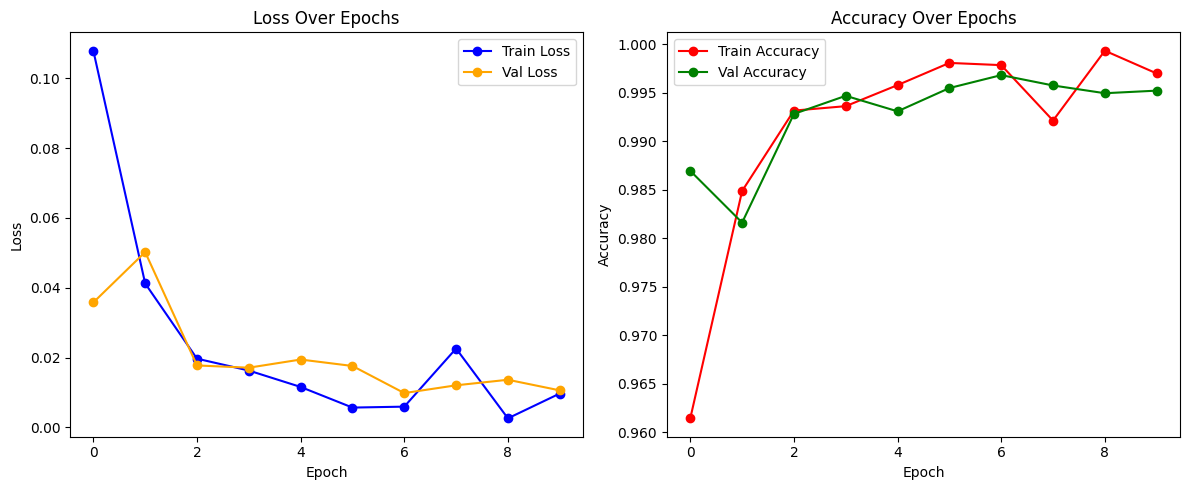

In [58]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(MobileNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(MobileNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(MobileNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(MobileNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Efficient Net Model

In [59]:
IMG_SIZE = 224
batch_size = 32


In [60]:
# Data generators
EffNet_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

EffNet_train_generator = EffNet_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)


Found 17500 validated image filenames belonging to 5 classes.


In [61]:
EffNet_train_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [62]:
EffNet_val_generator = EffNet_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3750 validated image filenames belonging to 5 classes.


In [63]:
EffNet_val_generator.class_indices

{'colon_aca': 0, 'colon_bnt': 1, 'lung_aca': 2, 'lung_bnt': 3, 'lung_scc': 4}

In [64]:
from tensorflow.keras.applications import EfficientNetB0

trained_EfficientNet_layers = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,3))


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [65]:
for layer in trained_EfficientNet_layers.layers:
    layer.trainable = False

In [66]:
with tf.device('/GPU:0'):
    # Build model
    EffNet_model = keras.models.Sequential([
    trained_EfficientNet_layers,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(len(EffNet_val_generator.class_indices), activation='softmax')
])


In [67]:
EffNet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [68]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='EffNet_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    )
]


In [69]:
# Compile
EffNet_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)


In [70]:
with tf.device('/GPU:0') :
    EffNet_history= EffNet_model.fit(
    EffNet_train_generator,
    validation_data=EffNet_val_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 106s 150ms/step - accuracy: 0.9352 - loss: 0.1934 - precision: 0.9517 - recall: 0.9114 - val_accuracy: 0.9816 - val_loss: 0.0449 - val_precision: 0.9819 - val_recall: 0.9813
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 62s 113ms/step - accuracy: 0.9796 - loss: 0.0535 - precision: 0.9797 - recall: 0.9792 - val_accuracy: 0.9877 - val_loss: 0.0345 - val_precision: 0.9877 - val_recall: 0.9875
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.9827 - loss: 0.0416 - precision: 0.9827 - recall: 0.9826 - val_accuracy: 0.9896 - val_loss: 0.0249 - val_precision: 0.9896 - val_recall: 0.9893
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 65s 118ms/step - accuracy: 0.9874 - loss: 0.0338 - precision: 0.9875 - recall: 0.9872 - val_accuracy: 0.9917 - val_loss: 0.0198 - val_precision: 0.9917 - val_recall: 0.9917
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - accuracy: 0.9937 - loss: 0.0180 - precision: 0.9939 - recall: 0.9937 - val_accuracy: 0.993

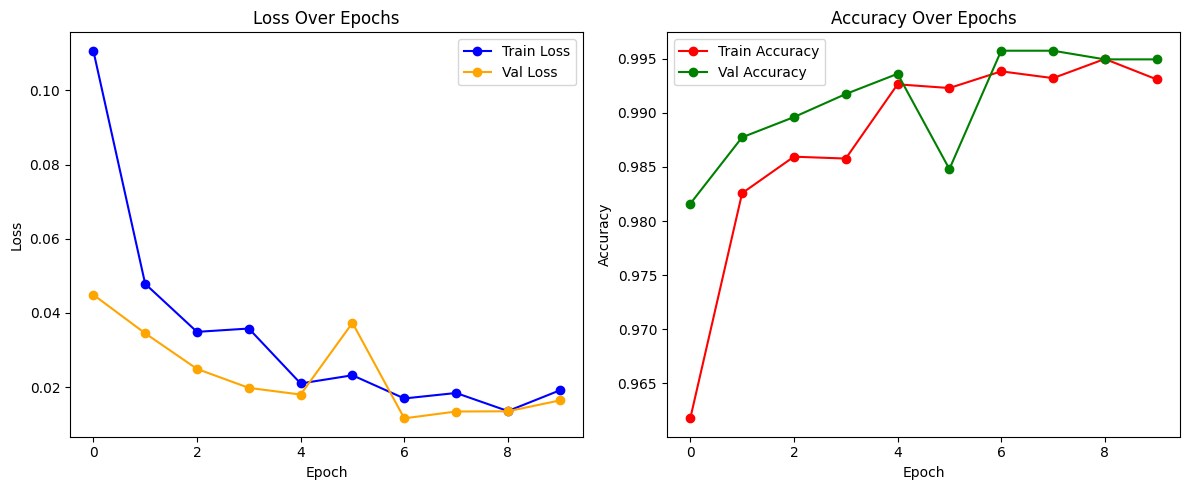

In [71]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(EffNet_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(EffNet_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(EffNet_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(EffNet_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Compare Between Models

In [72]:
history = {
    "CNN": {"accuracy": cnn_history.history['accuracy'],"val_accuracy": cnn_history.history['val_accuracy'] ,"loss": cnn_history.history['loss'],"val_loss": cnn_history.history['val_loss']},
    "MobileNetV2": {"accuracy": MobileNet_history.history['accuracy'],"val_accuracy": MobileNet_history.history['val_accuracy'], "loss": MobileNet_history.history['loss'],"val_loss": MobileNet_history.history['val_loss']},
    "VGG16": {"accuracy": VGG16_history.history['accuracy'],"val_accuracy": VGG16_history.history['val_accuracy'], "loss": VGG16_history.history['loss'],"val_loss": VGG16_history.history['val_loss']},
    "EffNet": {"accuracy": EffNet_history.history['accuracy'],"val_accuracy": EffNet_history.history['val_accuracy'], "loss": EffNet_history.history['loss'],"val_loss": EffNet_history.history['val_loss']},
    "ResNet50V2": {"accuracy": ResNet_history.history['accuracy'],"val_accuracy": ResNet_history.history['val_accuracy'], "loss": ResNet_history.history['loss'],"val_loss": ResNet_history.history['val_loss']}
}

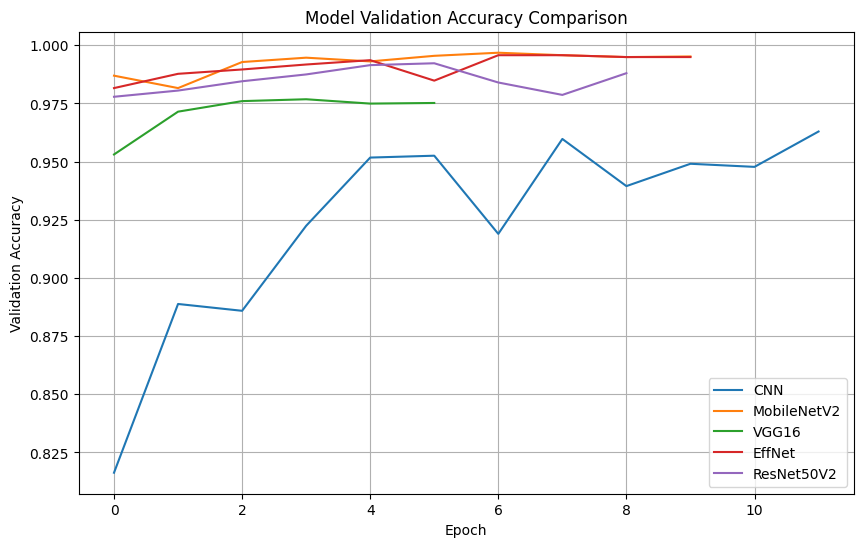

In [73]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_accuracy'], label=model)
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

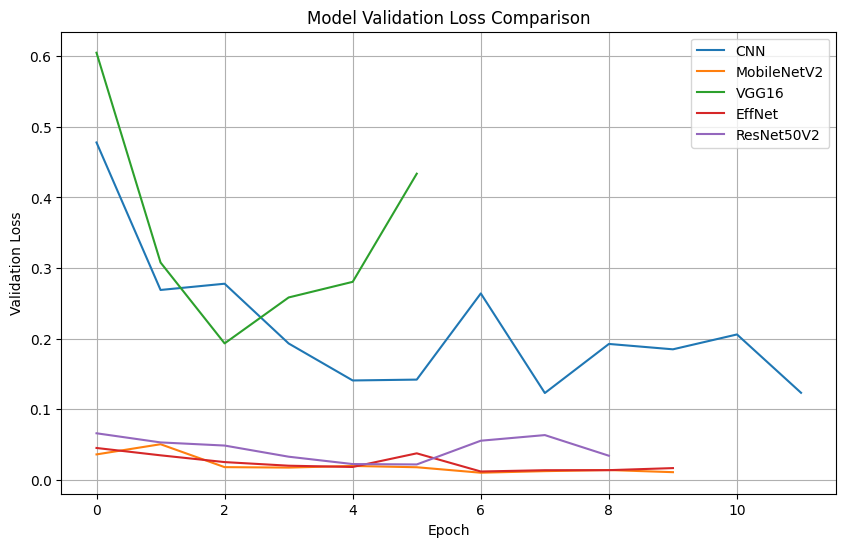

In [74]:
plt.figure(figsize=(10, 6))
for model, values in history.items():
    plt.plot(values['val_loss'], label=model)
plt.title('Model Validation Loss Comparison')
plt.ylabel('Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

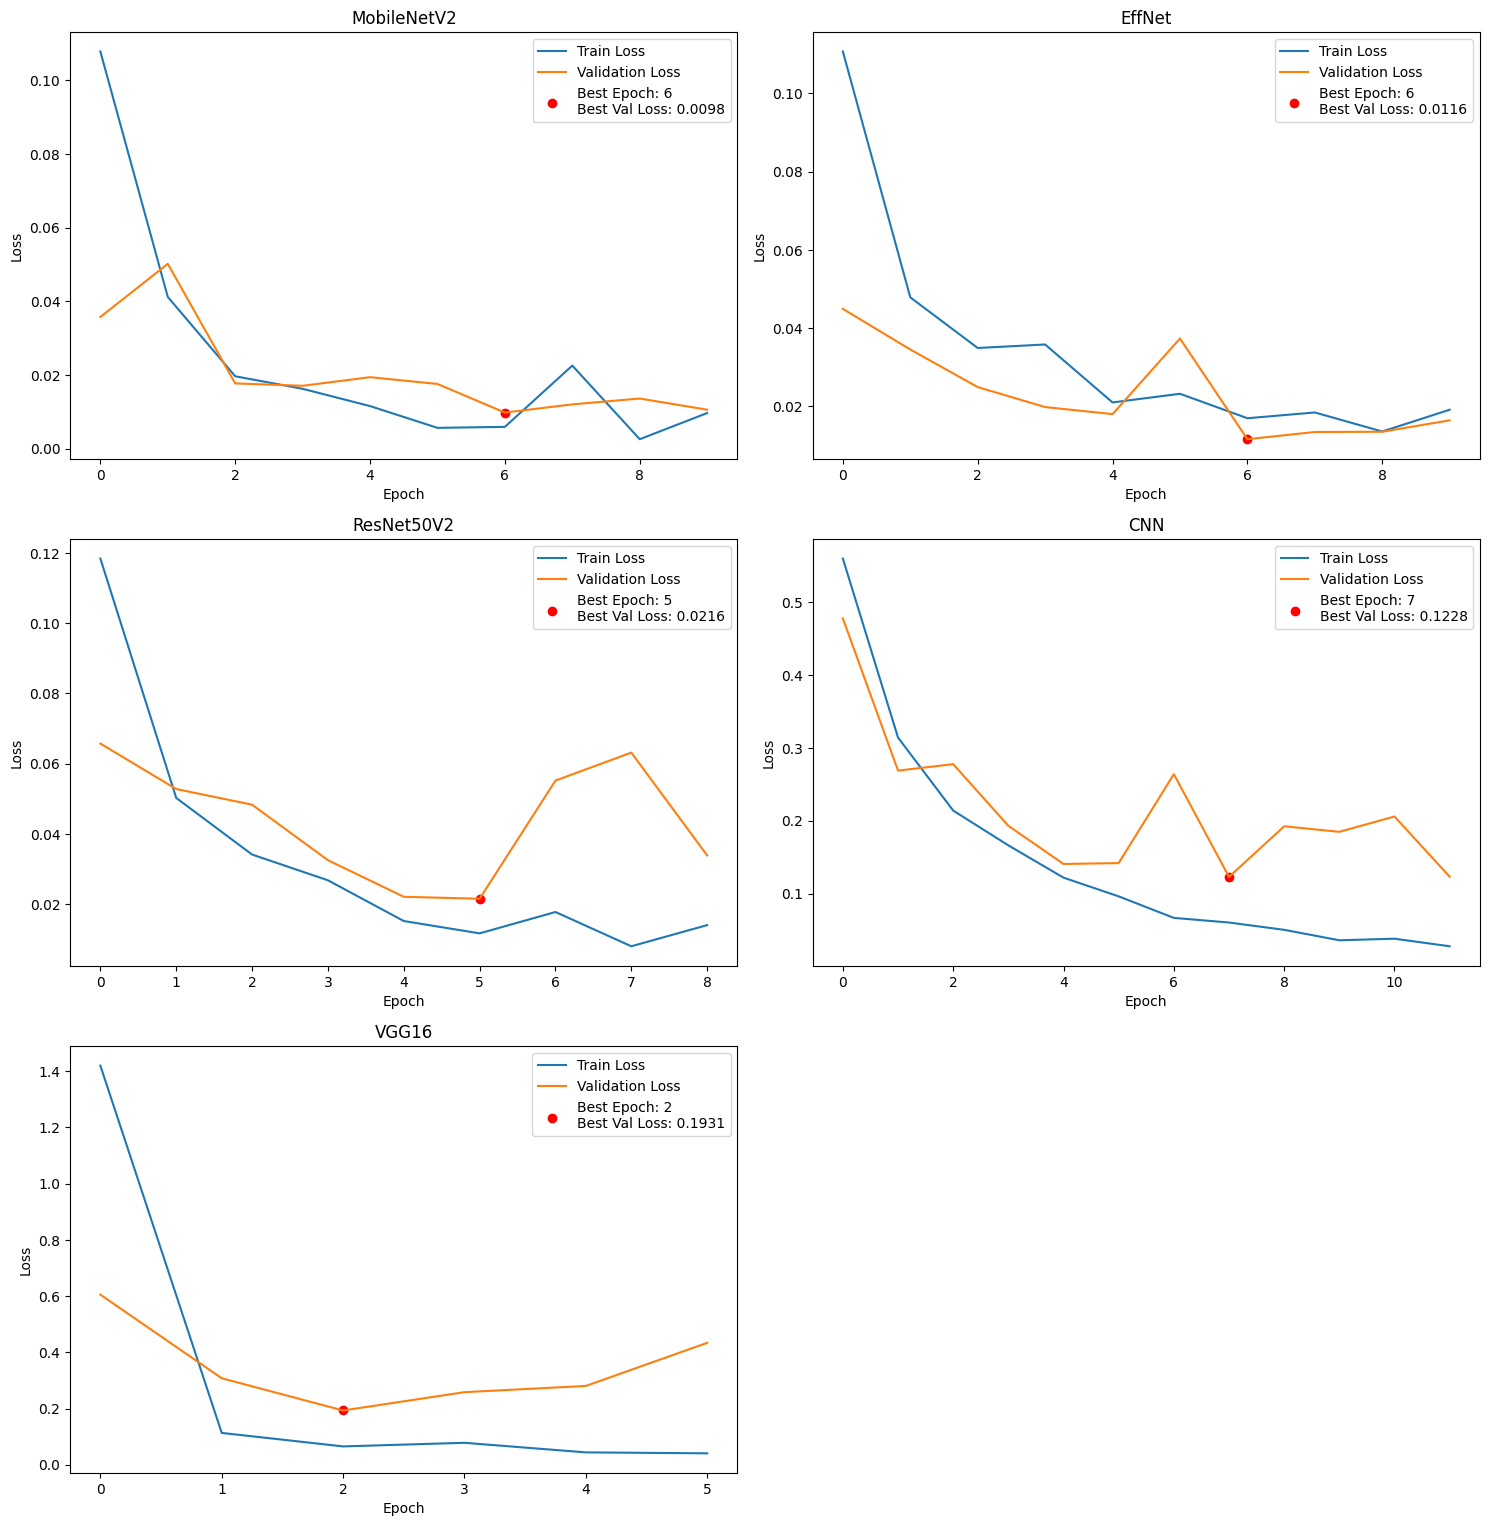

In [75]:
plt.figure(figsize=(15, 20))

# Sort models by least validation loss
sorted_models = sorted(history.items(), key=lambda x: min(x[1]['val_loss']))

# Plot each model based on sorted order of least val_loss
for i, (model_name, model_history) in enumerate(sorted_models, 1):
    plt.subplot(4, 2, i) 
    plt.plot(model_history['loss'], label='Train Loss')
    plt.plot(model_history['val_loss'], label='Validation Loss')

    # Find the best epoch based on least val_loss
    min_val_loss_epoch = model_history['val_loss'].index(min(model_history['val_loss']))
    min_val_loss = min(model_history['val_loss'])

    plt.scatter(min_val_loss_epoch, min_val_loss, color='red', label=f'Best Epoch: {min_val_loss_epoch}\nBest Val Loss: {min_val_loss:.4f}')

    plt.title(model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()


In [76]:
best_CNN = load_model('/kaggle/working/CNN_best_model.keras')
best_MobileNetV2 = load_model('/kaggle/working/MobileNet_best_model.keras')
best_VGG16 = load_model('/kaggle/working/VGG16_best_model.keras')
best_ResNet50 = load_model('/kaggle/working/ResNet_best_model.keras')

In [77]:
models = ['Best CNN','Best MobileNetV2','Best VGG16','Best EffNet','Best ResNest50']
best_train_accuracy= [
                        cnn_history.history['accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        EffNet_history.history['accuracy'][np.argmax(EffNet_history.history['val_accuracy'])],
                        ResNet_history.history['accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]
best_val_accuracy= [
                        cnn_history.history['val_accuracy'][np.argmax(cnn_history.history['val_accuracy'])],
                        MobileNet_history.history['val_accuracy'][np.argmax(MobileNet_history.history['val_accuracy'])],
                        VGG16_history.history['val_accuracy'][np.argmax(VGG16_history.history['val_accuracy'])],
                        EffNet_history.history['val_accuracy'][np.argmax(EffNet_history.history['val_accuracy'])],
                        ResNet_history.history['val_accuracy'][np.argmax(ResNet_history.history['val_accuracy'])]
                     ]

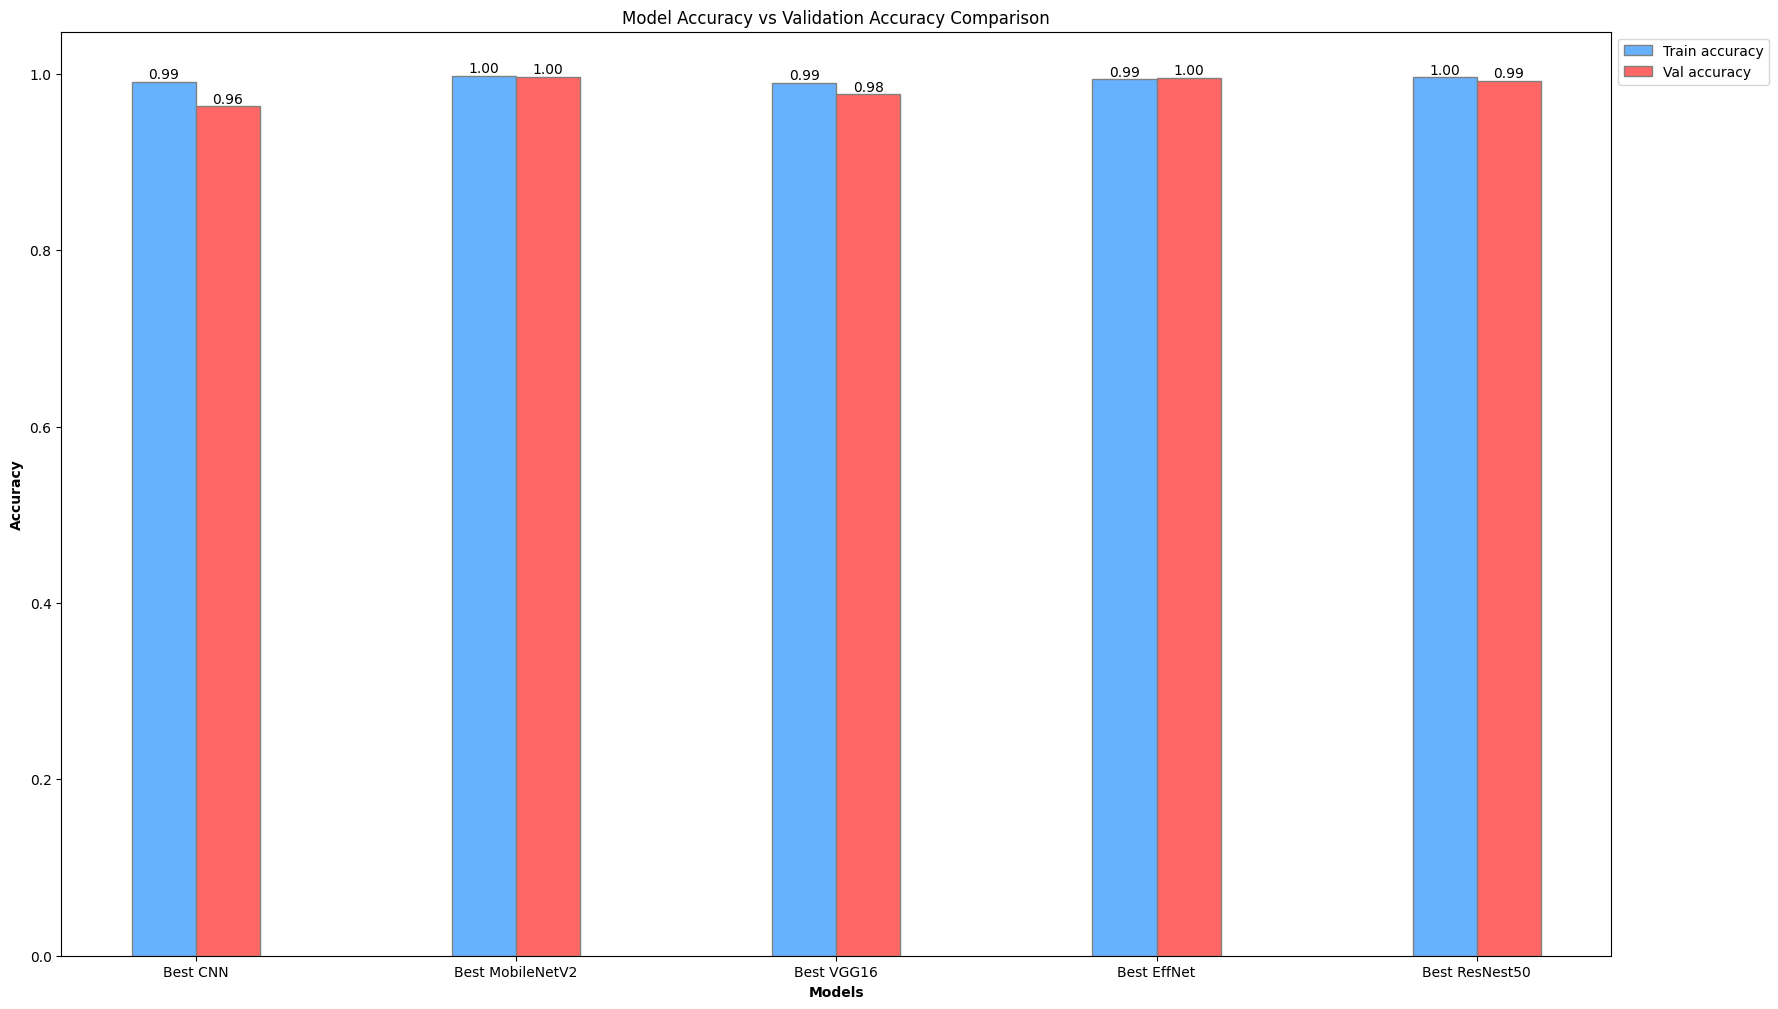

In [78]:
barWidth = 0.20

r1 = np.arange(len(best_train_accuracy))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(20, 12))
bars1 = plt.bar(r1, best_train_accuracy, color='#66B2FF', width=barWidth, edgecolor='grey', label='Train accuracy')
bars2 = plt.bar(r2, best_val_accuracy, color='#FF6666', width=barWidth, edgecolor='grey', label='Val accuracy')

plt.xlabel('Models', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(best_train_accuracy))], models)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Model Accuracy vs Validation Accuracy Comparison')
plt.show()

# The best model is MobileNetV2 with accurecy 100 % !!!!

In [79]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np

# Create ImageDataGenerator with the necessary preprocessing function
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_mobilenetv2)

# Create the data generator to load images from a dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Assuming test_df is the DataFrame containing test image paths and labels
    x_col='filepath',  # Column with image file paths
    y_col='label',  # Column with labels
    target_size=(224, 224),  # Resize images to 224x224 (the expected input size for MobileNetV2)
    batch_size=32,  # Number of samples per batch
    class_mode='categorical',  # For multi-class classification
    shuffle=False  # Don't shuffle the data for evaluation
)

# Get predictions using the model
cnn_predictions = cnn_model.predict(test_generator, verbose=1)
MobileNet_predictions = MobileNet_model.predict(test_generator, verbose=1)
VGG16_predictions = VGG16_model.predict(test_generator, verbose=1)
EffNet_predictions = EffNet_model.predict(test_generator, verbose=1)
ResNet_predictions = ResNet_model.predict(test_generator, verbose=1)

# Convert predictions to one-hot labels
cnn_pred_labels = np.argmax(cnn_predictions, axis=1)
MobileNet_pred_labels = np.argmax(MobileNet_predictions, axis=1)
VGG16_pred_labels = np.argmax(VGG16_predictions, axis=1)
EffNet_pred_labels = np.argmax(EffNet_predictions, axis=1)
ResNet_pred_labels = np.argmax(ResNet_predictions, axis=1)

# Get the true labels (as they are in the 'test_generator' dataset)
true_labels = test_generator.classes

# Generate confusion matrices
cnn_cm = confusion_matrix(true_labels, cnn_pred_labels)
MobileNet_cm = confusion_matrix(true_labels, MobileNet_pred_labels)
VGG16_cm = confusion_matrix(true_labels, VGG16_pred_labels)
EffNet_cm = confusion_matrix(true_labels, EffNet_pred_labels)
ResNet_cm = confusion_matrix(true_labels, ResNet_pred_labels)

# Print confusion matrices
print("CNN Confusion Matrix:\n", cnn_cm)
print("MobileNet Confusion Matrix:\n", MobileNet_cm)
print("VGG16 Confusion Matrix:\n", VGG16_cm)
print("EffNet Confusion Matrix:\n", EffNet_cm)
print("ResNet Confusion Matrix:\n",ResNet_cm)


Found 3750 validated image filenames belonging to 5 classes.
118/118 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step
118/118 ━━━━━━━━━━━━━━━━━━━━ 19s 133ms/step
CNN Confusion Matrix:
 [[ 71 123 279 272   5]
 [ 21 118   8 603   0]
 [  2   0 567 159  22]
 [  0   0  28 722   0]
 [  0   0 467  85 198]]
MobileNet Confusion Matrix:
 [[745   2   3   0   0]
 [  2 748   0   0   0]
 [  0   0 747   0   3]
 [  0   0   0 750   0]
 [  0   0  11   0 739]]
VGG16 Confusion Matrix:
 [[734  12   0   4   0]
 [108 642   0   0   0]
 [563  33  20  34 100]
 [ 69   9   0 670   2]
 [474  25   0   1 250]]
EffNet Confusion Matrix:
 [[  0   0 750   0   0]
 [  0   0 750   0   0]
 [  0   0 750   0   0]
 [  0   0 750   0   0]
 [  0   0 750   0   0]]
ResNet Confusion Matrix:
 [[746   2   2   0   0]
 [  3 747   0   0   0]
 [  0   0 736   1  13]
 [  0   0   0 750   0]
 [  0   0  12   0 738]]
